In [65]:
import pdb
from math import log10, floor

import numpy as np
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats

import emcee
import radvel

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
data = pd.read_csv('legacy_tables/system_props_719.csv')

In [85]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/legacy_analysis/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = smsyn['iso_fe'].tolist() + smemp['fe_emp'].tolist()

In [120]:
specmatch.query('name == "168009"').iso_parallax

202    3.816104
Name: iso_parallax, dtype: float64

In [86]:
specmatch.columns

Index(['Unnamed: 0', 'name', 'teff', 'teff_err', 'logg', 'logg_err', 'fe',
       'fe_err', 'vsini', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2',
       'iso_radius', 'iso_radius_err1', 'iso_radius_err2', 'iso_logage',
       'iso_logage_err1', 'iso_logage_err2', 'iso_age_err1', 'iso_age_err2',
       'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'iso_logg',
       'iso_logg_err1', 'iso_logg_err2', 'iso_fe', 'iso_fe_err1',
       'iso_fe_err2', 'iso_parallax', 'iso_parallax_err1', 'iso_parallax_err2',
       'teff_emp', 'teff_err_emp', 'radius_emp', 'radius_err_emp', 'fe_emp',
       'fe_err_emp'],
      dtype='object')

In [87]:
dwarfs = specmatch.query('teff_emp < 4700').reset_index()

In [88]:
masses_only = pd.read_csv('legacy_tables/planet_list_719.csv')

## Sort the planets into real, new candidates, known.

In [89]:
#masses_real = masses_real.loc[masses_real.status != 'B'].reset_index(drop=True)

masses_real = masses_only.query('status != "N" and status != "A"').reset_index(drop=True)
masses_good = masses_real.query('mass != "nan"').reset_index(drop=True)#[masses_only.hostname != 'hip63510']
masses_s = masses_good.query('status == "S" or status == "SS"').reset_index(drop=True)
masses_planet = masses_good.query('status != "S" and status != "SS"').reset_index(drop=True)
masses_old  = masses_planet.query('status == "K"').reset_index(drop=True)
masses_new  = masses_planet.query('status == "C" or status == "J"').reset_index(drop=True)

In [90]:
masses_planet.query('mass > 1 and axis > 0.5')

,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,per_minus,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus
0,0,145675,K,4.910311,4.930009,4.787921,5.071054,2.857071,2.856997,2.816439,...,1765.709724,1766.992785,88.895147,89.199999,88.713736,89.786000,0.366352,0.366356,0.362869,0.369773
1,1,145675,C,5.930104,6.186677,5.341438,7.168676,15.947416,17.505125,13.998808,...,19175.274377,40530.007386,46.782006,47.576763,43.540532,52.143361,0.427951,0.465702,0.362407,0.574290
11,15,104304,K,90.701092,123.911275,112.274176,134.563464,13.815738,22.931504,18.538946,...,28513.198219,53654.869009,703.898271,756.140668,736.762040,771.970301,0.273008,0.464029,0.376715,0.546100
12,17,10697,K,6.209813,6.207705,5.869961,6.538031,2.122787,2.123029,2.065401,...,1075.063774,1076.386013,115.986891,115.928407,114.752795,117.117671,0.100774,0.100541,0.092211,0.108566
14,20,108874,K,1.333800,1.332351,1.282319,1.382656,1.057444,1.057529,1.039940,...,395.122353,395.577508,37.082488,37.067601,36.365998,37.768731,0.141272,0.142805,0.125867,0.159414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,278,hip109388,K,1.030342,1.036577,0.987936,1.084759,2.604283,2.605747,2.574675,...,1930.143647,1954.693474,22.972952,23.118872,22.166835,24.046236,0.044826,0.036133,0.012154,0.065572
165,279,hip109388,C,1.280949,1.274642,1.207910,1.341802,5.347237,5.382638,5.286324,...,5646.158408,5901.661183,20.019145,19.869494,18.909229,20.831529,0.103437,0.101248,0.058544,0.145466
166,280,hip22627,K,1.163253,1.162807,1.094656,1.232546,3.000403,2.998109,2.951405,...,2299.999330,2365.785258,23.774027,23.752865,22.511503,25.015052,0.155343,0.137216,0.080241,0.190788
175,301,68988,K,16.389258,17.617583,15.124601,19.992019,14.353306,16.508762,12.742378,...,15046.331279,32532.222445,126.453866,132.159067,120.845171,141.813569,0.475855,0.533665,0.424231,0.623832


In [8]:
masses_only.query('hostname == "111031"')#[['axis_minus', 'axis_med', 'axis_plus']]

,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,per_minus,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus
22,22,111031,C,12.056604,32.91401,17.629905,57.28403,12.811619,24.715374,17.297921,...,24594.650355,66414.425194,90.72956,180.432225,110.876447,295.780887,0.163842,0.326113,0.154414,0.465122


## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [91]:
merge_columns = list(masses_good.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

masses_good['name'] = masses_good['hostname']
m_good_spec = pd.merge(masses_good, specmatch, on=['name'])

In [92]:
m_good_spec.columns

Index(['Unnamed: 0_x', 'hostname', 'status', 'mass', 'mass_med', 'mass_minus',
       'mass_plus', 'axis', 'axis_med', 'axis_minus', 'axis_plus', 'per',
       'per_med', 'per_minus', 'per_plus', 'k', 'k_med', 'k_minus', 'k_plus',
       'e', 'e_med', 'e_minus', 'e_plus', 'name', 'Unnamed: 0_y', 'teff',
       'teff_err', 'logg', 'logg_err', 'fe', 'fe_err', 'vsini', 'iso_mass',
       'iso_mass_err1', 'iso_mass_err2', 'iso_radius', 'iso_radius_err1',
       'iso_radius_err2', 'iso_logage', 'iso_logage_err1', 'iso_logage_err2',
       'iso_age_err1', 'iso_age_err2', 'iso_teff', 'iso_teff_err1',
       'iso_teff_err2', 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'iso_fe',
       'iso_fe_err1', 'iso_fe_err2', 'iso_parallax', 'iso_parallax_err1',
       'iso_parallax_err2', 'teff_emp', 'teff_err_emp', 'radius_emp',
       'radius_err_emp', 'fe_emp', 'fe_err_emp'],
      dtype='object')

## Take a look at imaging candidates. Convert semi-major axis to angular separation.

In [9]:
imaging_names = ['145675', '111031', '26161', '213472', '203473', '127506', '150554']

In [100]:
# Convert axis from AU to pc, then use parallax to convert to angular separation.
m_good_spec['sep'] = m_good_spec.axis/206265. * m_good_spec.iso_parallax

In [121]:
m_good_spec.iso_parallax

0      4.025709
1      4.025709
2      3.479597
3      3.479597
4      5.352651
         ...   
220    3.182628
221    3.182628
222    3.652091
223    2.890659
224    9.318217
Name: iso_parallax, Length: 225, dtype: float64

In [110]:
best_index = np.argsort(m_good_spec['sep'])

In [123]:
m_good_spec.query('name == "95735"').iso_parallax   #iloc[best_index[-30:],:].query('status == "K"')

174    9.279226
175    9.279226
Name: iso_parallax, dtype: float64

## Filter out planet candidates beyond 2 AU and above 0.1 M_Jup, and stars with measured metallicity < -0.6 (bad measurement).

In [67]:
good_spec_filter = m_good_spec.query('axis < 5 and mass > 0.1 and (status == "K" or status == "C")')#('fe > -0.6 and axis < 5 and mass > 0.1')
print(len(m_good_spec), len(good_spec_filter))
#good_spec_filter.sort_values('mass')

235 114


## Overplot total sample histogram in metallicity, and eccentricity/metallicity scatterplot for planets.

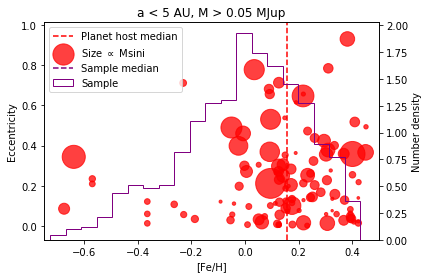

In [78]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')
ln1 = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                alpha=0.75, c='red', label=r'Size $\propto$ Msini')

#Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln2 = ax.axvline(x=median_fe, c='red', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
ax.set_xlim([-0.75, 0.5])

ax2 = ax.twinx()
ln3 = ax2.hist(fe_select, bins=40, histtype='step', color='purple', density=True, label='Sample')
median_sample_fe = np.median(fe_select)
#mad_sample_fe = astrostats.median_absolute_deviation(specmatch.fe)
mad_sample_fe = astrostats.mad_std(fe_select)
ln4 = ax2.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')
ax.axvline(x=median_sample_fe+mad_sample_fe, c='purple', ls=':')
ax.axvline(x=median_sample_fe-mad_sample_fe, c='purple', ls=':')
ax2.set_ylabel('Number density')
#ax2.set_xlim([-0.75, 0.5])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)

fig.savefig('planet_candidates/fe_eccentricity_hist.pdf')

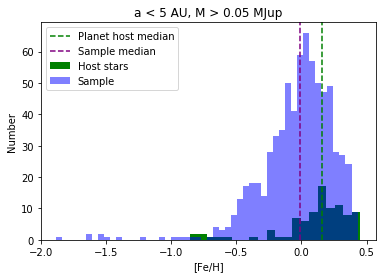

In [79]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')

# Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln1 = ax.hist(unique_fe, bins=20, histtype='stepfilled', color='green', 
              alpha=1, density=False, label='Host stars')
ln2 = ax.axvline(x=median_fe, c='green', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Number')

ln3 = ax.hist(fe_select, bins=50, histtype='stepfilled', color='blue', 
               alpha=0.5, density=False, label='Sample')
median_sample_fe = np.median(specmatch.fe)
mad_sample_fe = astrostats.mad_std(specmatch.fe)
ln4 = ax.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')

lines, labels = ax.get_legend_handles_labels()
ax.legend()

fig.savefig('planet_candidates/fe_two_hist_num.pdf')

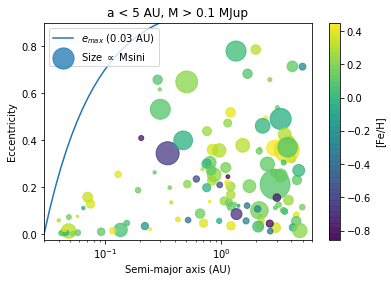

In [197]:
# Overplot peri-distance limit 0.03 AU.
axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes

fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.1 MJup')
im = ax.scatter(good_spec_filter.axis, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe, alpha=0.75, label=r'Size $\propto$ Msini')
ax.plot(axes, e_max, label=r'$e_{max}$ (0.03 AU)')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03,6])
ax.set_ylim([-0.025,0.9])
ax.set_xscale('log')
ax.legend(loc=2)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('[Fe/H]')#, rotation=270)
fig.savefig('planet_candidates/axis_eccentricity_log_lim.pdf')

# Explore the population's eccentricity distribution.

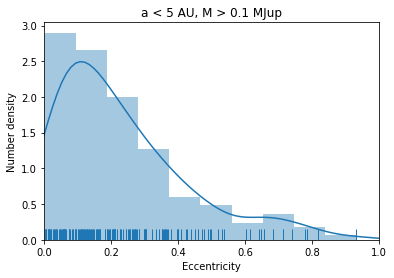

In [60]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('a < 5 AU, M > 0.1 MJup')
ax.set_xlim([0,1])
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_05.pdf')

## Fit Beta distribution to eccentricities. Define a likelihood function for the Beta distribution.

In [13]:
def beta(x, a, b):
    return spec.gamma(a+b)/(spec.gamma(a)*spec.gamma(b)) * x**(a-1) * (1-x)**(b-1)

def lnbetalike(theta, x, y, yerr):
    a, b = theta
    return -0.5*np.sum((y-beta(x, a, b))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

nll = lambda *args: -lnbetalike(*args)
# Kipping: a=0.867, b=3.03
def fit_beta(x, y, yerr, a_init=0.867, b_init=3.03): # Kipping estimates
    fit = op.minimize(nll, [a_init, b_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [14]:
e_pdf = np.histogram(masses_planet.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_planet.e, range=[0.001,1], density=False)
print(e_pdf[0])

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[2.86803658 2.53062051 1.91202438 1.06848421 0.67483214 0.16870803
 0.39365208 0.28118006 0.05623601 0.05623601]
[1.05406998 3.76549977]


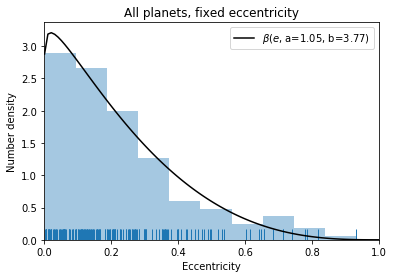

In [15]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit.
es = np.linspace(0.001, 1, num=100)
betas_fit = beta(es, fit[0], fit[1])
ax.plot(es, betas_fit, label=r'$\beta(e$, a=1.05, b=3.77)', c='black')
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_beta_fit_719.pdf')

## Explore Beta distribution posterior. NOT redrawing e's from posterior.

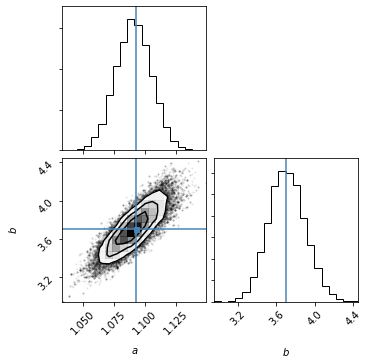

In [136]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnbetalike, args=(e_pdf[1][:-1], e_pdf[0], yerr,))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$a$", "$b$"],
                      truths=[fit[0], fit[1]])
fig.savefig("beta.pdf")

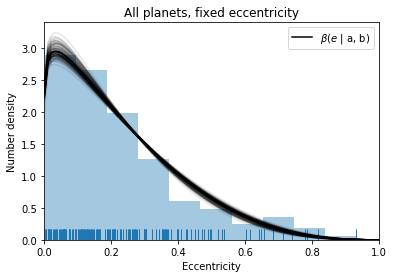

In [138]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, betas_fit, label=r'$\beta(e$ | a, b)', color='black')
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_beta_post_719.pdf')

## Repeat for half-Gaussian distribution.

In [16]:
def gauss(x, sig): # Defined for x >= 0 .
    return 2*np.exp(-(x/sig)**2)/np.sqrt(2*np.pi*sig**2)

def lngausslike(sig, x, y, yerr):
    return -0.5*np.sum((y-gauss(x, sig))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

ngll = lambda *args: -lngausslike(*args)
def fit_gauss(x, y, yerr, sig_init=0.2): # Who knows?
    fit = op.minimize(ngll, [sig_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [126]:
#ygerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
ygerr = 0.1*np.ones(10)
fitg = fit_gauss(e_pdf[1][:-1], e_pdf[0], yerr, sig_init=0.33)
print(fitg)

Optimization terminated successfully.
         Current function value: 13.878099
         Iterations: 2
         Function evaluations: 107
0.33407355268577765


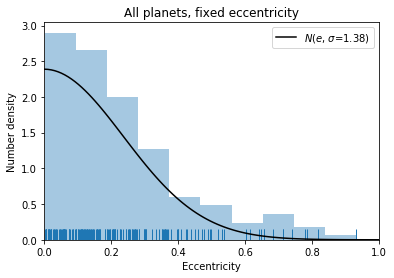

In [127]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit.
es = np.linspace(0.001, 1, num=100)
gausses_fit = gauss(es, fitg)
ax.plot(es, gausses_fit, label=r'$N(e$, $\sigma$=1.38)', c='black')
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_gauss_fit_719.pdf')

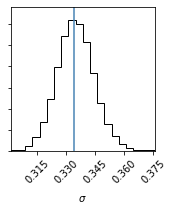

In [128]:
ndim, nwalkers = 1, 100
pos = [fitg + 5*1e-2*np.random.randn(ndim) for i in range(nwalkers)] 

samplerg = emcee.EnsembleSampler(nwalkers, ndim, lngausslike, args=(e_pdf[1][:-1], e_pdf[0], yerr))
samplerg.run_mcmc(pos, 500)

samplesg = samplerg.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samplesg, labels=[r'$\sigma$'],
                      truths=[fitg])
fig.savefig("gauss.pdf")

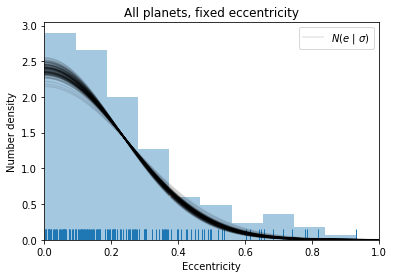

In [130]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Gaussian fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, gausses_fit, label=r'$N(e\ |\ \sigma$)', alpha=0.1, c='black')
for sig in samplesg[np.random.randint(len(samplesg), size=100)]:
    gausses = gauss(es, sig)
    ax.plot(es, gausses, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_gauss_post_719.pdf')

## Test hierarchical inference. Use Legacy catalog eccentricity posteriors. Block of code below shows how to generate synthetic posteriors, but not doing this anymore.

In [9]:
masses_noncirc = masses_planet.query('axis > 0.1')
masses_big_noncirc = masses_noncirc.query('mass > 0.1')

In [18]:
def bound(array):
    return np.random.choice(array[(array > 0) & (array < 1)], 500)

# Generate a population, synthetic posteriors, based on real MAP values and CIs. 
masses_noncirc = masses_planet.query('axis > 0.1')
e_minus = np.array(masses_noncirc.e_minus)
e_plus = np.array(masses_noncirc.e_plus)

posts = []
for i, e in enumerate(masses_noncirc.e):
    sig_e = 0.5*(e_plus[i] - e_minus[i])
    posts.append(bound(sig_e*np.random.randn(1000) + e))
posts = np.array(posts)

In [11]:
posts.shape

(151, 500)

In [10]:
# Define the population likelihood for the beta distribution. Can generalize later.
def popprob(samples, a, b):
    K = len(samples)    # Number of planets
    N = len(samples[0]) # Number of posterior samples
    
    sums = []
    for sample in samples:
        probs = beta(sample, a, b)
        sums.append(np.sum(probs)/N)
    return np.prod(sums) # *exp(−integral(Γ(e|θ)de)) (BUT THAT'S 1!)


def lnpoplike(theta, samples):
    a, b = theta
    return np.log(popprob(samples, a, b))

def lnpopprior(theta):
    a, b = theta
    if 0 < a < 10 and 0 < b < 50:
        return 0.0
    else:
        return -np.inf

def lnpopprob(theta, samples):
    lp = lnpopprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnpoplike(theta, samples)

In [413]:
print(fit[0], fit[1])
print(popprob(posts, fit[0], fit[1]))
print(lnpopprob([fit[0], fit[1]], posts))

1.0124604949030342 2.7081541713848116
1.2371570240232385e+26
60.08002844258765


In [13]:
e_pdf = np.histogram(masses_noncirc.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_noncirc.e, range=[0.001,1], density=False)

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) # Poisson uncertainty
yerr = 0.1*np.ones(10)
fit_noncirc = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit_noncirc)

[1.09233944 3.70026307]


## Try sampling!

In [188]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts,))
sampler.run_mcmc(pos, 1000)

(array([[1.15401043, 3.28541056],
        [1.27114459, 3.45738825],
        [0.82249519, 2.48897592],
        [0.83557037, 2.89682025],
        [0.91993995, 2.79383681],
        [0.89026728, 2.84798944],
        [0.95324024, 2.57851107],
        [1.05850081, 3.78168574],
        [1.09623135, 3.4531199 ],
        [0.78187352, 2.36440658],
        [1.01327479, 3.37186457],
        [1.00802546, 3.01833356],
        [1.1099652 , 3.37084064],
        [1.19117486, 3.21088899],
        [0.93701226, 2.94886827],
        [0.87496288, 2.66909973],
        [0.90301381, 2.44318771],
        [0.83956984, 2.38378298],
        [0.88469172, 2.63783076],
        [1.17982141, 3.00995034],
        [1.03110614, 2.99317744],
        [0.97100758, 2.88986269],
        [1.11903268, 3.18599966],
        [0.92558873, 2.32704521],
        [0.97212158, 2.66618001],
        [1.16042849, 2.87124315],
        [1.15387443, 3.29153844],
        [1.07440885, 2.95107037],
        [1.13893347, 3.8598507 ],
        [1.213

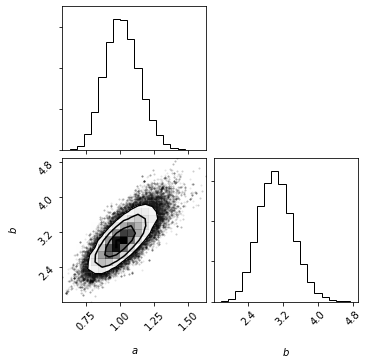

In [189]:
samples = sampler.chain[:, 20:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_all_median = np.median(samples[:, 0])
b_all_median = np.median(samples[:, 1])

fig = corner.corner(samples, labels=["$a$", "$b$"])#, truths=[fit_noncirc[0], fit_noncirc[1]])
fig.savefig("analysis_plots/corner_pop_K.pdf")

In [40]:
np.percentile(samples, [16, 50, 84], axis=0)

array([[0.88514987, 2.63480096],
       [1.00114476, 3.00934956],
       [1.12895945, 3.422142  ]])

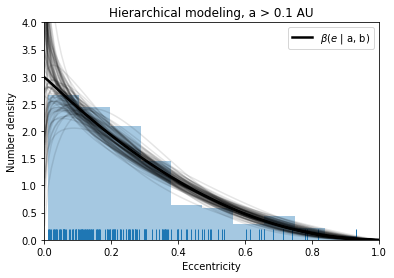

In [122]:
ax = sns.distplot(masses_noncirc.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Hierarchical modeling, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_all_median = beta(es, a_all_median, b_all_median)

ax.plot(es, beta_all_median, label=r'$\beta(e$ | a, b)', color='black', linewidth=2.5)
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_beta_whole_719.pdf')

## Separate the (observed) singles and multis. Need to add nplanets to the dataframe first.

In [14]:
names = np.unique(masses_noncirc.hostname)
nplanets = np.array(masses_noncirc.groupby('hostname').count()['status'])
db_nplanets = pd.DataFrame({'hostname':names, 'nplanets':nplanets})

masses_noncirc = pd.merge(masses_noncirc, db_nplanets, on='hostname').reset_index()

## Separate planets by mass, boundary at Msini = 0.1 Mjup (see mass histograms below). Leave in the planets within 0.1 AU for now.

In [11]:
planets_big_all   = masses_planet.query('mass > 0.1')
planets_small_all = masses_planet.query('mass <= 0.1')
planets_big     = masses_planet.query('mass > 0.1 and axis > 0.1')
planets_small   = masses_planet.query('mass <= 0.1 and axis > 0.1')

### Add number of planets again, WITHIN each sample. Number of planets with Msini less than 0.1 MJup, and number of planets with Msini greater than 0.1 MJup.

In [12]:
names_big = np.unique(planets_big_all.hostname)
nplanets_big = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big = pd.DataFrame({'hostname':names_big, 'nplanets':nplanets_big})

names_small = np.unique(planets_small.hostname)
nplanets_small = np.array(planets_small.groupby('hostname').count()['status'])
db_nplanets_small = pd.DataFrame({'hostname':names_small, 'nplanets':nplanets_small})

planets_big   = pd.merge(planets_big, db_nplanets_big, on='hostname').reset_index()
planets_small = pd.merge(planets_small, db_nplanets_small, on='hostname').reset_index()

planets_big_all   = pd.merge(planets_big_all, db_nplanets_big, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small, on='hostname').reset_index()

### Split giant planets into single-giant, multi-giant.

In [13]:
planets_big_single = planets_big.query('nplanets == 1 and mass > 0.1').reset_index()
planets_big_multi  = planets_big.query('nplanets != 1 and mass > 0.1').reset_index()

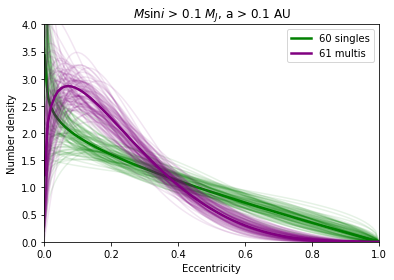

In [363]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
#ax.set_title('Boundary at 0.1 MJup')
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')

nsingle = len(planets_big_single)
nmulti  = len(planets_big_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label='{} singles'.format(nsingle), color='green', linewidth=2.5)
for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label='{} multis'.format(nmulti), color='purple', linewidth=2.5)
for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_synth_comparison_beta_big.pdf')

## Perform hierarchical inference with real posteriors.

### First, make re-sampled histogram of eccentricity posterior values. Do for all planets.

In [14]:
db_all = pd.read_csv('e_samples_all.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_all))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_all))
posts_all = []

for column in db_all.columns:
    if column == '26161_e1':
        posts_all.append(np.array(chains_26161['e']))
    elif column == '213472_e1':
        posts_all.append(np.array(chains_213472['e']))
    # Drop 159868, currently a bad fit. Fixed for next run.
    elif column == '159868_e1': # Sparse data for two planets, modeling one in run_719.
        pass
    elif column == '95128_e3': # Lick offset masquerading as planet.
        pass
    elif column == '217014_e2': # Lick offset masquerading as planet.
        pass
    else:
        posts_all.append(np.array(db_all[column]))
    
posts_all = np.array(posts_all[1:])  
db_all = None
chains_26161 = None
chains_213472 = None

In [31]:
posts_all[:,0].shape

(167,)

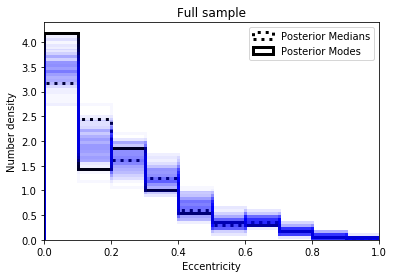

In [15]:
fig, ax = plt.subplots()

# Compute medians and approximate modes.
medians = np.median(posts_all, axis=1)
modes = []
for post in posts_all:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(modes, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Full sample')
ax.set_xlim([0, 1])
#ax.set_ylim([0, 4.5])

for i in np.arange(len(posts_all)):
    dist = posts_all[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='blue', label='_nolegend_', alpha=0.03)
ax.legend()

fig.savefig('analysis_plots/eccentricity_histogram_full.pdf')

In [16]:
db_big_noncirc = pd.read_csv('e_samples_big_noncirc.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_big_noncirc))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_big_noncirc))
posts_big_noncirc = []

for column in db_big_noncirc.columns:
    if column == '26161_e1':
        posts_big_noncirc.append(np.array(chains_26161['e']))
    elif column == '213472_e1':
        posts_big_noncirc.append(np.array(chains_213472['e']))
    # Drop bad fits from run_719. REMOVE AFTER NEXT RUN.
    elif column == '159868_e1': # Sparse data for two planets, modeling one in run_719.
        pass
    elif column == '95128_e3': # Lick offset masquerading as planet.
        pass
    #elif column == '181234_e1': # Underconstrained eccentric orbit. 
    #    pass
    else:
        posts_big_noncirc.append(np.array(db_big_noncirc[column]))
    
posts_big_noncirc = np.array(posts_big_noncirc[1:])  
db_big_noncirc = None
chains_26161 = None
chains_213472 = None

In [17]:
len(posts_big_noncirc)

112

### Make same histogram as full sample, for large & noncircular planets.

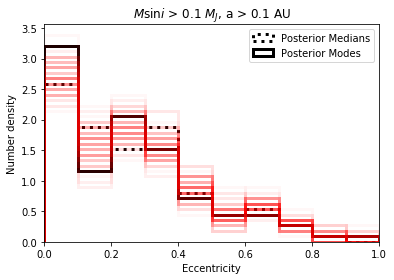

In [18]:
fig, ax = plt.subplots()

# Compute medians and approximate modes.
medians = np.median(posts_big_noncirc, axis=1)
modes = []
for post in posts_big_noncirc:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(modes, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
#ax.set_ylim([0, 4.5])

for i in np.arange(len(posts_big_noncirc)):
    dist = posts_big_noncirc[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='red', label='_nolegend_', alpha=0.03)
ax.legend()

fig.savefig('analysis_plots/eccentricity_histogram_big_noncirc.pdf')

In [64]:
masses_big_noncirc.reset_index().hostname[71]

'38529'

(array([1.09751869, 1.32347842, 1.2589185 , 0.87155896, 0.90383892,
        1.54943815, 2.45327707, 2.13047746, 3.00203642, 1.54943815]),
 array([0.01042927, 0.07238721, 0.13434515, 0.19630309, 0.25826104,
        0.32021898, 0.38217692, 0.44413486, 0.50609281, 0.56805075,
        0.63000869]),
 <a list of 1 Patch objects>)

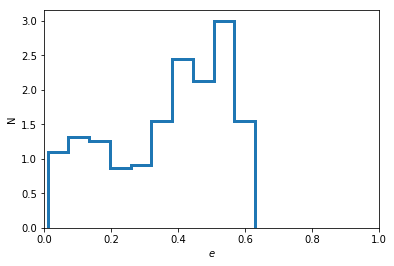

In [56]:
# Inspect some individual posteriors.
fig, ax = plt.subplots()
ax.set_xlabel(r'$e$')
ax.set_ylabel('N')
ax.set_xlim([0, 1])
ax.hist(posts_big_noncirc[72], density=True, histtype='step', lw=3) #107, wide one

In [23]:
len(posts_big_noncirc)

114

In [83]:
masses_big_noncirc = masses_noncirc.query('mass > 0.1').reset_index()

e_pdf = np.histogram(masses_big_noncirc.e, range=[0.001,1], density=True)
print(e_pdf[0])

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[2.48182066 1.90272918 1.98545653 1.32363769 0.91000091 0.24818207
 0.57909149 0.41363678 0.08272736 0.08272736]
Optimization terminated successfully.
         Current function value: 14.984094
         Iterations: 22
         Function evaluations: 901
[1.01246049 2.70815417]


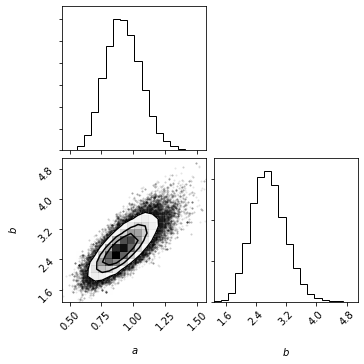

In [160]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_noncirc = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_noncirc,))
sampler_big_noncirc.run_mcmc(pos, 1000)

samples_big_noncirc = sampler_big_noncirc.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_noncirc_median = np.median(samples_big_noncirc[:, 0])
b_big_noncirc_median = np.median(samples_big_noncirc[:, 1])

fig = corner.corner(samples_big_noncirc, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_noncirc.pdf")

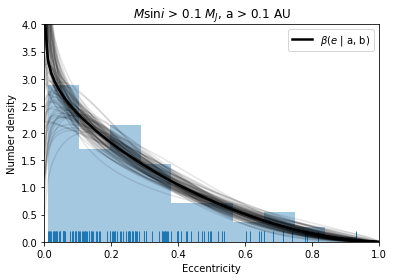

In [161]:
ax = sns.distplot(masses_big_noncirc.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_median = beta(es, a_big_noncirc_median, b_big_noncirc_median)

ax.plot(es, beta_median, label=r'$\beta(e$ | a, b)', color='black', linewidth=2.5)
for a, b in samples_big_noncirc[np.random.randint(len(samples_big_noncirc), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_noncirc_real.pdf')

## Cold gas giants.

In [517]:
db_cold = pd.read_csv('e_samples_cold.csv').sample(200)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_cold))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_cold))
posts_cold = []

for column in db_cold.columns:
    if column == '26161_e1':
        posts_cold.append(np.array(chains_26161['e1']))
    elif column == '213472_e1':
        posts_cold.append(np.array(chains_213472['e1']))
    # Drop 159868, currently a bad fit. Fixed for next run.
    elif column == '159868_e1':
        pass
    elif column == '95128_e3': # Lick offset masquerading as planet.
        pass
    else:
        posts_cold.append(np.array(db_cold[column]))
    
posts_cold = np.array(posts_cold[1:])    
db_cold = None
chains_26161 = None
chains_213472 = None

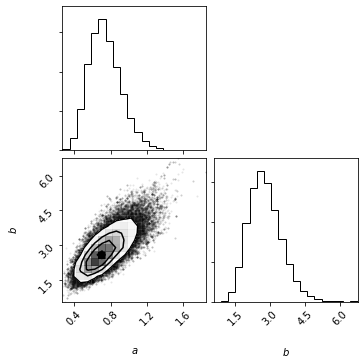

In [150]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_cold = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_cold,))
sampler_cold.run_mcmc(pos, 1000)

samples_cold = sampler_cold.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_cold_median = np.median(samples_cold[:, 0])
b_cold_median = np.median(samples_cold[:, 1])

fig = corner.corner(samples_cold, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_cold.pdf")

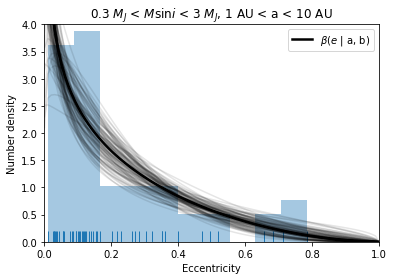

In [186]:
masses_cold = masses_noncirc.query('mass > 0.3 and mass < 3 and axis > 1 and axis < 10')

ax = sns.distplot(masses_cold.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'0.3 $M_J$ < $M$sin$i$ < 3 $M_J$, 1 AU < a < 10 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_median = beta(es, a_cold_median, b_cold_median)

ax.plot(es, beta_median, label=r'$\beta(e$ | a, b)', color='black', linewidth=2.5)
for a, b in samples_cold[np.random.randint(len(samples_cold), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_cold_real.pdf')

In [493]:
total   = len(posts_cold) 
nonzero = 0

for post in posts_cold:
    median = np.median(post)
    dev = np.std(post)
    #print(median, dev)
    if median > 3*dev:
        nonzero += 1
        
print(nonzero/total)

0.5


In [397]:
48*0.6666666666666666

32.0

## Big singles & multis.

In [28]:
db_big_single = pd.read_csv('e_samples_big_single_noncirc.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_big_single))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_big_single))
posts_big_single = []

for column in db_big_single.columns:
    if column == '26161_e1':
        posts_big_single.append(np.array(chains_26161['e']))
    elif column == '213472_e1':
        posts_big_single.append(np.array(chains_213472['e']))
    # Drop 159868, currently a bad fit. Fixed for next run.
    elif column == '159868_e1':
        pass
    elif column == '95128_e3': # Lick offset masquerading as planet.
        pass
    else:
        posts_big_single.append(np.array(db_big_single[column]))
    
posts_big_single = np.array(posts_big_single[1:])    
db_big_single = None
chains_26161 = None
chains_213472 = None

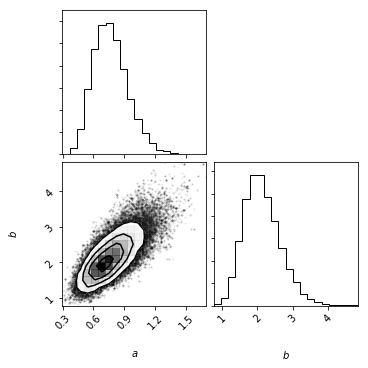

In [29]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_single = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_single,))
sampler_big_single.run_mcmc(pos, 1000)

samples_big_single = sampler_big_single.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_single_median = np.median(samples_big_single[:, 0])
b_big_single_median = np.median(samples_big_single[:, 1])

fig = corner.corner(samples_big_single, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_single_noncirc.pdf")

In [520]:
samples_big_single

array([[1.01831795, 2.76260425],
       [1.03592099, 2.83656193],
       [0.9070412 , 2.44493495],
       ...,
       [0.79545302, 2.1754576 ],
       [0.72882375, 1.99330342],
       [0.70071307, 1.93967951]])

In [384]:
np.percentile(samples_big_single, [16, 50, 84], axis=0)

array([[0.59179186, 1.6381641 ],
       [0.73931661, 2.08510236],
       [0.91441369, 2.61067953]])

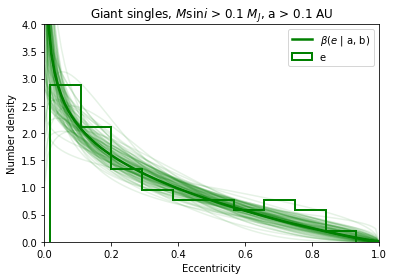

In [32]:
fig, ax = plt.subplots()

#ax = sns.distplot(planets_big_multi.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.hist(planets_big_single.e, bins=10, density=True, histtype='step', lw=2, color='green')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label=r'$\beta(e$ | a, b)', color='green', linewidth=2.5)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='green', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_single_noncirc.pdf')

In [35]:
db_big_multi = pd.read_csv('e_samples_big_multi_noncirc.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_big_multi))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_big_multi))
posts_big_multi = []

for column in db_big_multi.columns:
    if column == '26161_e1':
        posts_big_multi.append(np.array(chains_26161['e']))
    elif column == '213472_e1':
        posts_big_multi.append(np.array(chains_213472['e']))
    # Drop 159868, currently a bad fit. Fixed for next run.
    elif column == '159868_e1':
        pass
    elif column == '95128_e3':
        pass    
    else:
        posts_big_multi.append(np.array(db_big_multi[column]))
    
posts_big_multi = np.array(posts_big_multi[1:])    
db_big_multi = None
chains_26161 = None
chains_213472 = None

In [34]:
len(posts_big_multi)

60

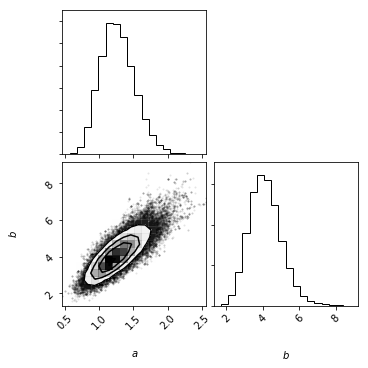

In [36]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_multi = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_multi,))
sampler_big_multi.run_mcmc(pos, 1000)

samples_big_multi = sampler_big_multi.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_multi_median = np.median(samples_big_multi[:, 0])
b_big_multi_median = np.median(samples_big_multi[:, 1])

fig = corner.corner(samples_big_multi, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_multi_noncirc.pdf")

In [525]:
np.percentile(samples_big_multi, [16, 50, 84], axis=0)

array([[1.02193153, 3.27184474],
       [1.24558094, 4.04286831],
       [1.50700565, 4.94830324]])

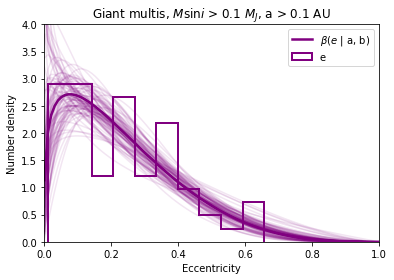

In [37]:
fig, ax = plt.subplots()

#ax = sns.distplot(planets_big_multi.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.hist(planets_big_multi.e, bins=10, density=True, histtype='step', lw=2, color='purple')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant multis, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_multi_noncirc.pdf')

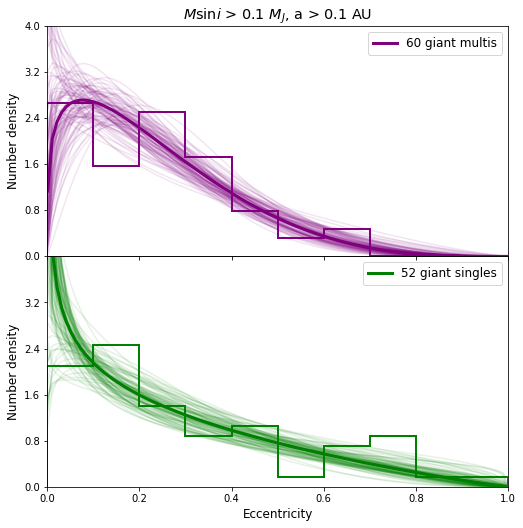

In [39]:
#matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(8, 8))

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('Eccentricity', fontsize='large')
ax1.set_ylabel('Number density', fontsize='large')
ax1.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 4])

# Plot histogram of singles.
ax1.hist(planets_big_single.e, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='green', label='_nolegend_')

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax1.plot(es, beta_big_single_median, label=r'{} giant singles'.format(nsingle), 
         color='green', linewidth=3)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax1.plot(es, betas, c='green', alpha=0.1)
ax1.legend(fontsize = 'large')

# Remove topmost tick mark from bottom panel.
nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Number density', fontsize='large')
ax2.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 4])

ax2.hist(planets_big_multi.e, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='purple', label='_nolegend_')
#label=r'$\beta(e$ | a, b)'

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax2.plot(es, beta_big_multi_median, label=r'{} giant multis'.format(nmulti), 
         color='purple', linewidth=3)
ax2.set_xticklabels('')

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax2.plot(es, betas, c='purple', alpha=0.1)
ax2.legend(fontsize = 'large')

ax2.yaxis.set_major_locator(MaxNLocator(nbins=nbins))

fig.savefig('analysis_plots/eccentricity_pop_hist_comparison.pdf')

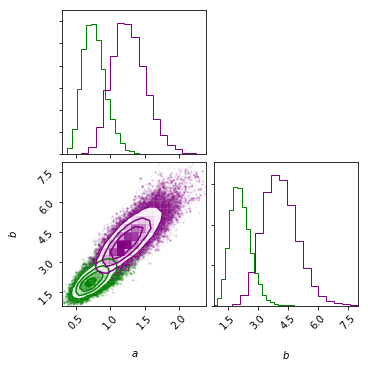

In [40]:
## Plot the two distributions on top of each other.
fig = corner.corner(samples_big_single, labels=["$a$", "$b$"], color='green')#, quantiles=[0.16, 0.5, 0.84])
corner.corner(samples_big_multi, fig=fig, color='purple')#, quantiles=[0.16, 0.5, 0.84])
# Histogram limits.
fig.axes[0].set_xlim([0.3, 2.4])
fig.axes[3].set_xlim([0.8, 8])
# Scatterplot limits.
fig.axes[2].set_xlim([0.3, 2.4])
fig.axes[2].set_ylim([0.8, 8])
# Plots to clarify.
#fig.axes[0].set_title(r'$M$sin$i$ > 0.1 $M_J$' + ' \na > 0.1 AU')
#fig.axes[3].set_title('Green: singles \nPurple: multis')
fig.savefig("analysis_plots/corner_real_big_noncirc_comparison.pdf")

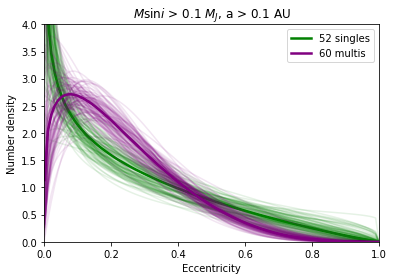

In [41]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label='{} singles'.format(nsingle), color='green', linewidth=2.5)
for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label='{} multis'.format(nmulti), color='purple', linewidth=2.5)
for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_real_comparison_beta_big_noncirc.pdf')

## Make observational stats histograms.

In [6]:
obs_stats = pd.read_csv('legacy_tables/observation_stats.csv')
obs_stats = obs_stats.query('baseline > 2922 and Nobs > 17')
obs_stats.columns

Index(['Unnamed: 0', 'Nobs', 'Nobs_CORAVEL', 'Nobs_apf', 'Nobs_j', 'Nobs_k',
       'Nobs_lick', 'Nobs_mcdonald', 'baseline', 'baseline_CORAVEL',
       'baseline_apf', 'baseline_j', 'baseline_k', 'baseline_lick',
       'baseline_mcdonald', 'med_err_CORAVEL', 'med_err_apf', 'med_err_j',
       'med_err_k', 'med_err_lick', 'med_err_mcdonald', 'name'],
      dtype='object')

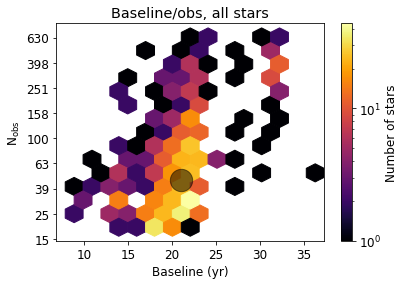

In [86]:
fig, ax = plt.subplots()

logobs   = np.log10(obs_stats.Nobs)
baseyear = obs_stats.baseline/365.25
#extent=(8.5, 35, 16, 630)
minobs  = np.amin(logobs)
maxobs  = np.amax(logobs)
minbase = np.amin(baseyear)
maxbase = np.amax(baseyear)
hard_extent = (minbase-2, maxbase+2, minobs-0.07, maxobs+0.06)

hb = ax.hexbin(baseyear, logobs, gridsize=15, bins='log', 
               extent=hard_extent, cmap='inferno', mincnt=1)

matplotlib.rcParams.update({'font.size': 12})
ax.set_title("Baseline/obs, all stars")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')

median_base = np.median(baseyear)
median_obs  = np.log10(np.median(obs_stats.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.

def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D.pdf')

## Make same plot for stars with planets.

In [30]:
plnames = np.unique(masses_good.hostname)
obs_known = obs_stats.loc[obs_stats['name'].isin(plnames)]
obs_none = obs_stats.loc[~obs_stats['name'].isin(plnames)]

In [31]:
len(obs_known)

160

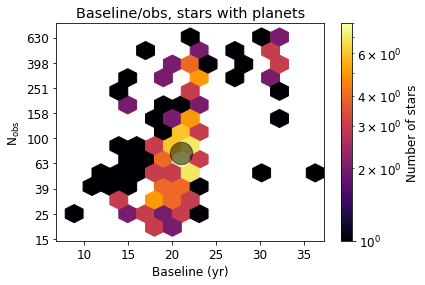

In [87]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_known.baseline/365.25, np.log10(obs_known.Nobs), 
               extent=hard_extent, gridsize=15, bins='log', 
               cmap='inferno', mincnt=1)
ax.set_title("Baseline/obs, stars with planets")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')

median_base = np.median(obs_known.baseline/365.25)
median_obs  = np.log10(np.median(obs_known.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D_planets.pdf')

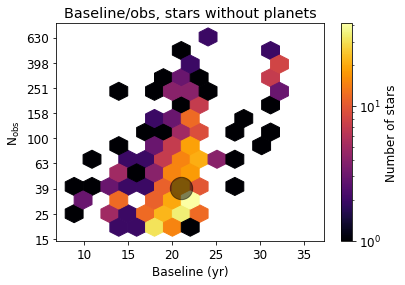

In [88]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_none.baseline/365.25, np.log10(obs_none.Nobs), 
               extent=hard_extent, gridsize=15, bins='log', 
               cmap='inferno', mincnt=1)
ax.set_title("Baseline/obs, stars without planets")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')
#ax.set_ylabel(r'log$_{10}$(N$_\mathrm{obs}$)')

median_base = np.median(obs_none.baseline/365.25)
median_obs  = np.log10(np.median(obs_none.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D_none.pdf')

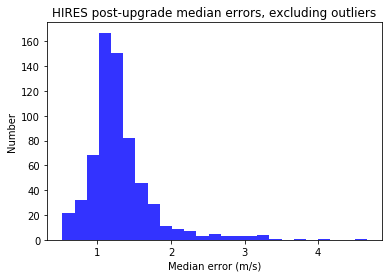

In [162]:
fig, ax = plt.subplots()
ax.hist(obs_stats.query('med_err_j < 5').med_err_j, bins=25, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('HIRES post-upgrade median errors, excluding outliers')
fig.savefig('legacy_tables/hist_HIRES_post_err.pdf')

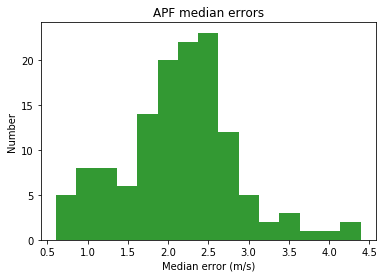

In [168]:
fig, ax = plt.subplots() #.query('med_err_j < 5')
ax.hist(obs_stats.med_err_apf, bins=15, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('APF median errors')
fig.savefig('legacy_tables/hist_APF_err.pdf')

Text(0.5, 1.0, 'Total baseline distribution')

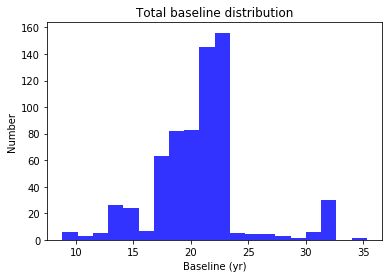

In [178]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline/365.25, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('Total baseline distribution')

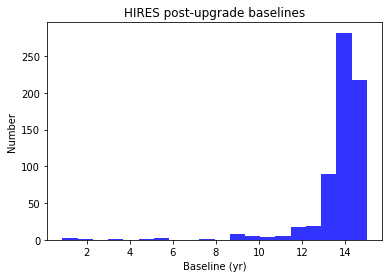

In [179]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_j/365.25, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('HIRES post-upgrade baselines')
fig.savefig('legacy_tables/hist_HIRES_post_base.pdf')

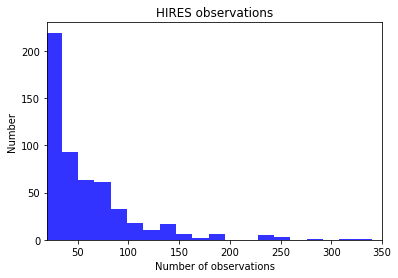

In [180]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_j + obs_stats.Nobs_k, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('HIRES observations')
fig.savefig('legacy_tables/hist_HIRES_nobs.pdf')

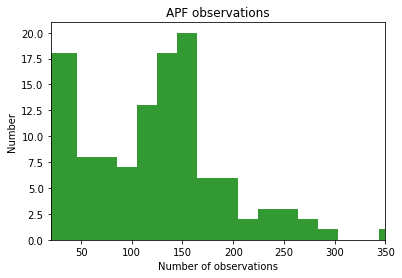

In [143]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_apf, bins=20, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('APF observations')
fig.savefig('legacy_tables/hist_APF_nobs.pdf')

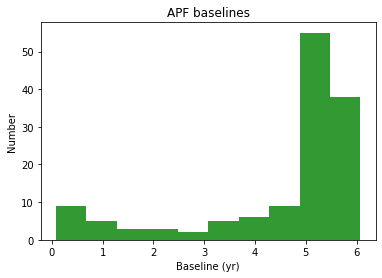

In [145]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_apf/365.25, bins=10, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('APF baselines')
fig.savefig('legacy_tables/hist_APF_base.pdf')

## Examine mass and period distributions.

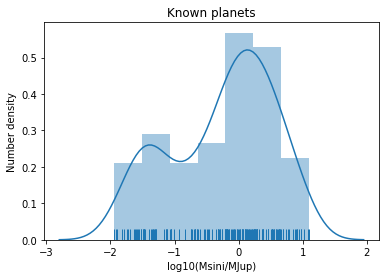

In [18]:
axold = sns.distplot(np.log10(masses_planet.query('mass < 15')['mass']), rug=True)
axold.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axold.set_title('Known planets')
fig = axold.get_figure()
fig.savefig('planet_candidates/mass_histogram_all_log.pdf')

In [17]:
masses_close = masses_planet.query('axis < 1 and mass < 15')
masses_mid   = masses_planet.query('axis > 1 and axis < 3 and mass < 15')
masses_far   = masses_planet.query('axis > 3 and mass < 15')

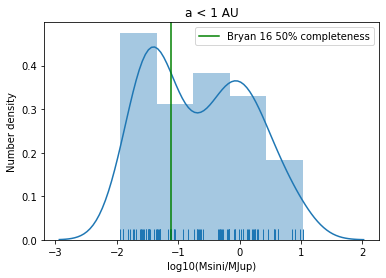

In [22]:
mclose = masses_close.mass
thresh_close = np.log10(0.075) #50% completeness threshold

axclose = sns.distplot(np.log10(mclose), kde=True, rug=True)
axclose.axvline(thresh_close, c='g', label='Bryan 16 50% completeness')
axclose.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axclose.set_title('a < 1 AU')
axclose.legend()

figclose = axclose.get_figure()
figclose.savefig('planet_candidates/close_histogram.pdf')

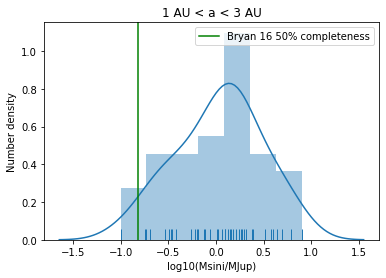

In [20]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

axmid = sns.distplot(np.log10(mmid), rug=True)
axmid.axvline(thresh_mid, c='g', label='Bryan 16 50% completeness')
axmid.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axmid.set_title('1 AU < a < 3 AU')
axmid.legend()

figmid = axmid.get_figure()
figmid.savefig('planet_candidates/middle_histogram.pdf')

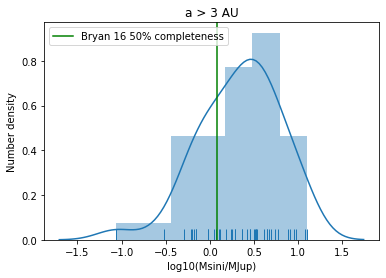

In [21]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

axfar = sns.distplot(np.log10(mfar), rug=True)
axfar.axvline(thresh_far, c='g', label='Bryan 16 50% completeness')
axfar.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axfar.set_title('a > 3 AU')
axfar.legend()

figfar = axfar.get_figure()
figfar.savefig('planet_candidates/far_histogram.pdf')

## Make distributions of periods and period ratios.

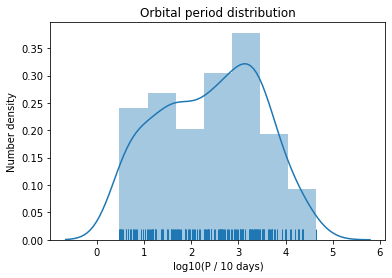

In [137]:
# Only use ratios below 20.
axper = sns.distplot(np.log10(masses_planet.per), rug=True)
axper.set(xlabel='log10(P / 10 days)', ylabel='Number density')
axper.set_title('Orbital period distribution')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_histogram.pdf')

In [133]:
def period_ratios(pers):
    ratios = []
    nplanets = len(pers)
    sorted = np.sort(pers)
    for i in np.arange(nplanets):
        for j in np.arange(i):
            ratios.append(sorted[i]/sorted[j])
    return ratios

In [134]:
systems = masses_planet.hostname.unique()

In [135]:
all_ratios = []
for system in systems:
    sys_db = masses_planet.query('hostname == "{}"'.format(system))#    .loc[masses_planet.hostname == system]
    if len(sys_db) > 1:
        sys_ratios = period_ratios(sys_db.per)
        all_ratios.append(sys_ratios)
all_ratios = np.concatenate(all_ratios)

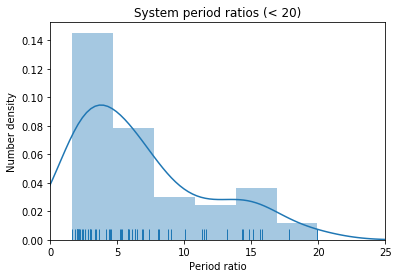

In [136]:
# Only use ratios below 20.
filtered_ratios = np.extract(all_ratios < 20, all_ratios)
axper = sns.distplot(filtered_ratios, rug=True)
axper.set_xlim([0,25])
axper.set(xlabel='Period ratio', ylabel='Number density')
axper.set_title('System period ratios (< 20)')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_ratio_histogram.pdf')

## Catalogue trend systems.

In [ ]:
trends = masses_only.loc[masses_only.per > 5*10**3]

## Identify resonant systems.

In [14]:
res = [4., 3., 2., 3./2., 4./3.]
names = np.unique(masses_planet.hostname)
resnames = []

for name in names:
    subsec = masses_planet.query('hostname == "{}"'.format(name)).sort_values(by='per')
    pers = np.array(subsec.per)
    nps = len(subsec)
    if nps > 1:
        planets = np.arange(nps)
        for i in planets:
            for j in planets[~(planets == i)]:
                if np.any(np.abs(pers[i]/pers[j] - res) < 0.2):
                    resnames.append(name)
    
resnames = np.unique(resnames)

In [15]:
resnames

array(['128311', '141399', '155358', '164922', '219134', '37124', '50499',
       '75732', '7924', '82943', '95128', 'hip109388'], dtype='<U9')

(array([3.31071167, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.31071167, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 3.31071167, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 3.31071167, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.31071167, 0.        , 3.31071167, 0.        , 0.        ,
        3.31071167, 3.31071167, 0.        , 3.31071167, 0.        ,
        0.        , 3.31071167, 0.        , 3.31071167, 3.31071167]),
 array([-0.83532544, -0.81015462, -0.7849838 , -0.75981298, -0.73464216,
        -0.70947134, -0.68430051, -0.65912969, -0.63395887, -0.60878805,
        -0.58361723, -0.5584464 , -0.53327558, -0.50810476, -0.48293394,
        -0.45776312, -0.4325923 , -0.40742147, -0.38225065, -0.35707983,
        -0.33190901, -0.30

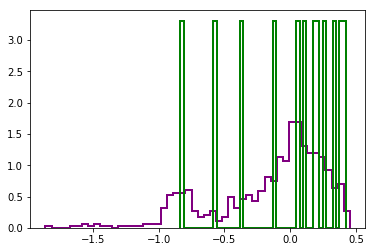

In [16]:
specmatch_res = specmatch.query('name in ["128311", "141399", "155358", "164922", "219134", \
                                "37124", "50499", "75732", "7924", "82943", "95128", "hip109388"]')

fig, ax = plt.subplots()
ax.hist(specmatch.fe, bins=50, density=True, histtype='step', lw=2, color='purple')
ax.hist(specmatch_res.fe, bins=50, density=True, histtype='step', lw=2, color='green')

In [17]:
m_good_spec.columns

Index(['Unnamed: 0_x', 'hostname', 'status', 'mass', 'mass_med', 'mass_minus',
       'mass_plus', 'axis', 'axis_med', 'axis_minus', 'axis_plus', 'per',
       'per_med', 'per_minus', 'per_plus', 'k', 'k_med', 'k_minus', 'k_plus',
       'e', 'e_med', 'e_minus', 'e_plus', 'name', 'Unnamed: 0_y', 'teff',
       'teff_err', 'logg', 'logg_err', 'fe', 'fe_err', 'vsini', 'iso_mass',
       'iso_mass_err1', 'iso_mass_err2', 'iso_radius', 'iso_radius_err1',
       'iso_radius_err2', 'iso_logage', 'iso_logage_err1', 'iso_logage_err2',
       'iso_age_err1', 'iso_age_err2', 'iso_teff', 'iso_teff_err1',
       'iso_teff_err2', 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'iso_fe',
       'iso_fe_err1', 'iso_fe_err2', 'teff_emp', 'teff_err_emp', 'radius_emp',
       'radius_err_emp', 'fe_emp', 'fe_err_emp'],
      dtype='object')

In [18]:
m_spec_giants = m_good_spec.query('mass > 0.1')

In [19]:
len(m_spec_giants)

193

In [20]:
giant_names = np.unique(m_spec_giants.name)
print(giant_names)

['102195' '103829' '104067' '104304' '10697' '107148' '10790' '108874'
 '111031' '112914' '114174' '114729' '114762' '114783' '116321' '117176'
 '117207' '11964a' '120066' '120136' '12661' '126614' '127506' '128311'
 '129814' '130322' '134987' '136925' '13931' '139457' '141399' '142229'
 '142267' '143761' '144287' '145675' '145934' '145958a' '147231' '154345'
 '155358' '156279' '157338' '159062' '159868' '16141' '16160' '161797'
 '164922' '165401' '167042' '167215' '167665' '168443' '168746' '169830'
 '170469' '17382' '175541' '177830' '178911b' '179949' '181234' '183263'
 '18445' '185414' '186427' '187123' '188015' '18803' '190360' '190406'
 '191408' '192263' '195019' '200565' '209458' '210277' '211681' '213472'
 '215578' '217014' '217107' '217165' '218566' '219134' '219834b' '22049'
 '222582' '239960' '24040' '26161' '29461' '30649' '3130-1591-1' '31412'
 '31423' '32963' '33636' '34445' '3651' '37124' '3765' '3795' '38529'
 '40647' '40979' '4203' '4208' '45350' '46375' '4747' '49674'

In [21]:
specmatch_giant = m_spec_giants.drop_duplicates(subset='name')

In [22]:
len(specmatch_giant)

150

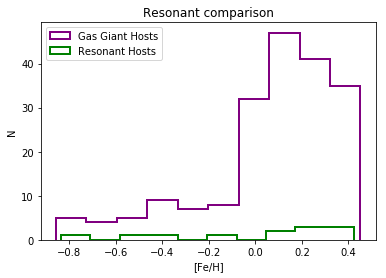

In [27]:
fig, ax = plt.subplots()
ax.hist(m_spec_giants.fe, density=False, histtype='step', lw=2, color='purple', label='Gas Giant Hosts')
ax.hist(specmatch_res.fe, density=False, histtype='step', lw=2, color='green', label='Resonant Hosts')
ax.set_title('Resonant comparison')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('N')
ax.legend(loc=2)
fig.savefig('analysis_plots/resonant_fe_histogram.pdf')

## Do some preliminary work on giant multis.

In [51]:
planets_big_all   = masses_planet.query('mass > 0.1')
planets_small_all = masses_planet.query('mass <= 0.1')

names_big_all = np.unique(planets_big_all.hostname)
nplanets_big_all = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big_all = pd.DataFrame({'hostname':names_big_all, 'nplanets':nplanets_big_all})

names_small_all = np.unique(planets_small_all.hostname)
nplanets_small_all = np.array(planets_small_all.groupby('hostname').count()['status'])
db_nplanets_small_all = pd.DataFrame({'hostname':names_small_all, 'nplanets':nplanets_small_all})

# Do same nplanets thingy for all planets, no mass cuts.
names_all = np.unique(masses_planet.hostname)
nplanets_all = np.array(masses_planet.groupby('hostname').count()['status'])
db_nplanets_all = pd.DataFrame({'hostname':names_all, 'nplanets':nplanets_all})

planets_all       = pd.merge(masses_planet, db_nplanets_all, on='hostname').reset_index()
planets_big_all   = pd.merge(planets_big_all, db_nplanets_big_all, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small_all, on='hostname').reset_index()

db_nplanets_all       = None
db_nplanets_big_all   = None
db_nplanets_small_all = None

In [52]:
planets_big_multi_all = planets_big_all.query('nplanets > 1')
planets_multi_all     = planets_all.query('nplanets > 1')

In [54]:
planets_multi_all#.query('axis < 0.1')

,index,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus,nplanets
0,0,0,145675,K,4.910311,4.930009,4.787921,5.071054,2.857071,2.856997,...,1766.992785,88.895147,89.199999,88.713736,89.786000,0.366352,0.366356,0.362869,0.369773,2
1,1,1,145675,C,5.930104,6.186677,5.341438,7.168676,15.947416,17.505125,...,40530.007386,46.782006,47.576763,43.540532,52.143361,0.427951,0.465702,0.362407,0.574290,2
2,2,3,1461,K,0.020355,0.020306,0.017841,0.022745,0.064313,0.064308,...,5.771590,2.259221,2.236886,1.980627,2.488020,0.205714,0.106661,0.032319,0.222443,2
3,3,4,1461,K,0.026585,0.025502,0.022323,0.028718,0.113359,0.113344,...,13.506274,2.198567,2.115421,1.862548,2.363000,0.146231,0.099673,0.029296,0.208099,2
4,4,7,155358,K,0.813886,0.865033,0.798673,0.960423,0.610034,0.610154,...,194.665990,34.060234,36.085216,33.509826,39.798742,0.234480,0.220992,0.200525,0.241666,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,296,37124,K,0.637897,0.640130,0.619796,0.660753,0.518332,0.518312,...,154.284286,28.561279,28.665014,28.053847,29.291120,0.059637,0.056707,0.035441,0.077248,3
172,172,297,37124,K,0.649051,0.619548,0.530565,0.702714,1.664450,1.664722,...,890.370274,16.308536,15.600438,13.407645,17.579617,0.121206,0.115839,0.066544,0.167875,3
173,173,298,37124,K,0.634029,0.636568,0.599151,0.675442,2.630263,2.631182,...,1778.509984,12.580575,12.886264,12.118451,13.730575,0.012403,0.165263,0.053224,0.289636,3
174,174,300,68988,K,1.969198,1.970428,1.885562,2.053510,0.071213,0.071212,...,6.276428,192.104859,192.214938,191.571474,192.855609,0.157166,0.156755,0.153332,0.160005,2


In [57]:
# Follow resonant identification recipe.
def dispersion(mass_db):
    hostnames = np.unique(mass_db.hostname)
    
    disp_array = []
    for name in hostnames:
        system = mass_db.query('hostname == "{}"'.format(name)).sort_values(by='mass')    
        nps = len(system)
        if nps > 1:
            mass_av = np.mean(system.mass)
            disp_sys = np.sqrt(np.sum((system.mass - mass_av)**2) / (nps - 1))
            disp_array.append(disp_sys)
        
    return np.mean(disp_array)

In [58]:
dispersion(planets_big_multi_all)

1.6991663494845828

In [59]:
dispersion(planets_multi_all)

1.2358802304632246